In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import statsmodels.api as sm
from scipy import stats
import pwlf
from sklearn import mixture
import scipy.linalg as la
from statsmodels.graphics.gofplots import qqplot_2samples
from scipy import stats
from scipy.interpolate import CubicSpline
from localreg import *
import os.path
from os import path

from matplotlib import gridspec

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import Normalize

import matplotlib.lines as mlines

# Loading R packages

In [2]:
import rpy2
# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
# R package names
packnames = ('lokern')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))


from rpy2.robjects import FloatVector

lokern = rpackages.importr('lokern')

In [3]:
#%matplotlib qt

# First experiment Sorter and Image Data for Unit Conversion

In [4]:
#Using first experiment data with images to determine a scaling between sorter and real measurements

data_all = []
with open('raw_cleaned.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        data_all.append(row)

headerS = list(np.array(data_all[0])[[0,1,12,14,15,20,17,18,19]])

dataS = np.array(data_all)[1:,[0,1,12,14,15,20,17,18,19]]
for i in range(len(dataS)):
    dataS[i,1] = dataS[i,1][-1]

dataS = dataS.astype(float)

medianTOF = np.empty((int(np.max(dataS[:,0])),int(np.max(dataS[:,1])),int(np.max(dataS[:,2]))))
medianEXT = np.empty((int(np.max(dataS[:,0])),int(np.max(dataS[:,1])),int(np.max(dataS[:,2]))))
medianNEXT = np.empty((int(np.max(dataS[:,0])),int(np.max(dataS[:,1])),int(np.max(dataS[:,2]))))

for t in range(int(np.max(dataS[:,0]))):
    for r in range(int(np.max(dataS[:,1]))):
        for c in range(int(np.max(dataS[:,2]))):
            TOF = dataS[np.logical_and(np.logical_and(dataS[:,0]==t+1,dataS[:,1]==r+1)
                                                             ,dataS[:,2]==c+1),3]
            EXT = dataS[np.logical_and(np.logical_and(dataS[:,0]==t+1,dataS[:,1]==r+1)
                                                             ,dataS[:,2]==c+1),4]
            NEXT = dataS[np.logical_and(np.logical_and(dataS[:,0]==t+1,dataS[:,1]==r+1)
                                                             ,dataS[:,2]==c+1),5]
            medianTOF[t,r,c] = np.median(TOF)
            medianEXT[t,r,c] = np.median(EXT)
            medianNEXT[t,r,c] = np.median(NEXT)

nRed = dataS[:,-1]/(dataS[:,4])

medianRED = np.empty((int(np.max(dataS[:,0])),int(np.max(dataS[:,1])),int(np.max(dataS[:,2]))))
times = np.empty((int(np.max(dataS[:,0])),int(np.max(dataS[:,1])),int(np.max(dataS[:,2]))))
for t in range(int(np.max(dataS[:,0]))):
    for r in range(int(np.max(dataS[:,1]))):
        for c in range(int(np.max(dataS[:,2]))):
            RED = nRed[np.logical_and(np.logical_and(dataS[:,0]==t+1,dataS[:,1]==r+1)
                                                             ,dataS[:,2]==c+1)]
            medianRED[t,r,c] = np.median(RED)
            times[t,r,c] = t+1


red = np.ndarray.flatten(medianRED)
T = np.ndarray.flatten(times)
T = T[~np.isnan(red)]
red = red[~np.isnan(red)]

data_allI = []
with open('all_student_measurements.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        data_allI.append(row)
        
header_allI = list(np.array(data_allI[0]))

student = np.array(data_allI[1:])[:,5]

headerI = ['Hour', 'replicate', 'well', 'length', 'width']

names = np.unique(student)

dataI = np.array(data_allI[1:])[:,[2,4,4,7,8]]

for i in range(len(dataI)):
    dataI[i,1] = ord(dataI[i,1][0])-64
    dataI[i,2] = dataI[i,2][1:]

dataI = dataI.astype(float)

hours = np.unique(dataI[:,1])

Length = dataI[:,3]
Width = dataI[:,4]

header_combined = ['replicate','hour','well','TOF','length','norm.EXT','width', 'EXT']
medians_combined = np.zeros((6*11*72,8))
count = 0
for t in range(72):
    SortTime = dataS[dataS[:,0]==t+1]
    ImTime = dataI[dataI[:,0].astype(float)==t+1]
    for r in range(6):
        SortRep = SortTime[SortTime[:,1]==r+1]
        ImRep = ImTime[ImTime[:,1]==r+1]
        wellnames = np.unique(ImRep[:,2])
        for w in wellnames:
            SortWell = SortRep[SortRep[:,2]==w]
            ImWell = ImRep[ImRep[:,2]==w]
            timeofflight = SortWell[:,3]
            extinction = SortWell[:,5]
            length = ImWell[:,3]
            width = ImWell[:,4]
            ext = SortWell[:,4]
            medians_combined[count] = np.array([r+1,t+1,w,np.median(timeofflight),np.median(length),
                                               np.median(extinction),np.median(width),np.median(ext)])
            count+=1
medians_combined=medians_combined[medians_combined[:,0]!=0]

TOF_length = np.poly1d(np.polyfit(medians_combined[:,3],medians_combined[:,4], 1))
nEXT_width = np.poly1d(np.polyfit(medians_combined[:,5],medians_combined[:,6], 1))

def VolumeS(tof,normEXT):
    return np.multiply(TOF_length(tof),np.square(np.divide(nEXT_width(normEXT),2.)))*np.pi
def VolumeI(length, width):
    return np.multiply(length,np.square(np.divide(width,2.)))*np.pi

/Users/joy/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joy/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Full Population Calculations

In [ ]:
data_strain = []
with open('strains_cleaned.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        data_strain.append(row)

In [ ]:
header = list(np.array(data_strain[0])[[2,7,10,9]])
strain_data = np.array(data_strain)[1:,3]
strain_types = np.unique(strain_data)
dataSS = np.array(data_strain)[1:,[2,7,10,9]].astype(float)

In [ ]:
L1 = [[1,10],[1,10],[1,10],[1,10]]
L2 = [[15.854,22.744],[18.937,26.810],[18.928,24.878],[15.445,22.701]]
L3 = [[26.086,32.261],[30.239,36.737],[28.975,35.458],[26.344,32.679]]
stages = [L1,L2,L3]

In [ ]:
iterations = 5000
fit_TOFs_boot = np.empty((4,3,iterations,100))
fit_nEXTs_boot = np.empty((4,3,iterations,100))
regtime_s = np.empty((4,3,100))

for t in range(len(strain_types)):
    for s in range(3):
        stage = stages[s][t]
        hourmin = np.ceil(stage[0])
        hourmax = np.floor(stage[1])
        boot_all_data = dataSS[np.logical_and(strain_data == strain_types[t],
                                              np.logical_and(dataSS[:,0]>=hourmin, dataSS[:,0]<=hourmax))]
        boot_tof = boot_all_data[:,1]
        boot_next = boot_all_data[:,2]
        boot_time = boot_all_data[:,0]
        regtime_s[t,s] = np.linspace(hourmin,hourmax,100)
        numbersamples = len(boot_tof)
        
        for i in range(iterations):
            count = np.arange(numbersamples)
            pick = np.random.choice(count,numbersamples,replace = True)
            subset_tof = boot_tof[pick]
            subset_next = boot_next[pick]
            subset_time = boot_time[pick]
            fit_TOFs_boot[t,s,i] = lokern.lokerns(FloatVector(subset_time),FloatVector(subset_tof),0, 100,
                                                FloatVector(regtime_s[t,s]),False, 2, True)[3]
            fit_nEXTs_boot[t,s,i] = lokern.lokerns(FloatVector(subset_time),FloatVector(subset_next),0, 100,
                                                FloatVector(regtime_s[t,s]),False, 2, True)[3]
    print('Finished with strain: '+strain_types[t])
  

In [ ]:
lfit = TOF_length(fit_TOFs_boot)
wfit = nEXT_width(fit_nEXTs_boot)

fit_dl_boot = np.empty((4,3,iterations,100))
fit_dw_boot = np.empty((4,3,iterations,100))
mean_dw = np.empty((4,3,100))
mean_dl = np.empty((4,3,100))

for r in range(4):
    for s in range(3):
        fit_dl_boot[r,s] = np.gradient(lfit[r,s],regtime_s[r,s],axis = 1)
        fit_dw_boot[r,s] = np.gradient(wfit[r,s],regtime_s[r,s],axis = 1)
        mean_dl[r,s] = np.gradient(np.mean(lfit[r,s],axis = 0),regtime_s[r,s])
        mean_dw[r,s] = np.gradient(np.mean(wfit[r,s],axis = 0),regtime_s[r,s])

LWcov = np.empty((2,2,4,3,100))

for r in range(4):
    for s in range(3):
        for t in range(100):
            l = fit_dl_boot[r,s,:,t]
            w = fit_dw_boot[r,s,:,t]
            lw = np.array([l,w])
            LWcov[:,:,r,s,t] = np.cov(lw)

error = np.sqrt(np.divide(LWcov[1,1],np.square(mean_dl))+
                np.divide(np.square(mean_dw)*LWcov[0,0],np.power(mean_dl,4))-
                np.divide(2*mean_dw*LWcov[0,1],np.power(mean_dl,3)))

In [ ]:

c_cycle = ['#4477AA', '#117733', '#DDCC77']

for r in range(4):
    Rep = r+1
    plt.subplot(2,2,Rep)
    for s in range(3):
        plt.plot(regtime_s[r,s],
                 np.divide(mean_dw[r,s],mean_dl[r,s]),
                 color = c_cycle[s])
        plt.fill_between(regtime_s[r,s],np.divide(mean_dw[r,s],mean_dl[r,s])-error[r,s],
                         np.divide(mean_dw[r,s],mean_dl[r,s])+error[r,s], color = c_cycle[s],alpha = 0.4)

    plt.xlabel('Time (hour)', fontsize = 15)
    plt.ylabel('Slope: $\\frac{dW}{dL}$', fontsize = 15)
    #plt.title('Slopes for all Replicates', fontsize = 20)
    plt.title('Fit to Strain ' + strain_types[r], fontsize = 20)
    plt.ylim([-0.10,1])
plt.show()

In [ ]:
datalength = TOF_length(dataSS[:,1])
datawidth = nEXT_width(dataSS[:,2])
for r in range(4):
    
    gs = gridspec.GridSpec(2,2) 
    maxtime = stages[-1][r][1]*1.1
    plt.subplot(2,2,r+1)
    plt.hist2d(datalength[np.logical_and(strain_data == strain_types[r],dataSS[:,0]<=maxtime)],
               datawidth[np.logical_and(strain_data == strain_types[r],dataSS[:,0]<=maxtime)],
                   bins = 100, cmap = 'gray', zorder = 0)
    plt.ylabel('Width ($\mu m$)')
    plt.xlabel('Length ($\mu m$)')

    for s in range(3):
        plt.plot(np.mean(lfit[r,s],axis = 0),
                 np.mean(wfit[r,s],axis = 0)
                 ,color = c_cycle[s],lw = 2, zorder = 5)
        counts,xbins,ybins = np.histogram2d((lfit[r,s]).flatten(),(wfit[r,s]).flatten(),
                                            bins=100,normed=True)
        plt.contourf(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     colors = c_cycle[s],
                     alpha = 0.4, levels = [0.1*np.max(counts),np.max(counts)], zorder = 5)
        plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     colors = c_cycle[s],
                     linewidths = 0.5, levels = [0.1*np.max(counts)], zorder = 5)
    plt.title('Strain '+strain_types[r])
plt.show()

# Median Data Calculations

In [5]:
data_strain = []
with open('all_strains_medians.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        data_strain.append(row)

In [6]:
header = list(np.array(data_strain[0]))
strain_data = np.array(data_strain)[1:,0]
strain_types = np.unique(strain_data)
dataSS = np.array(data_strain)[1:,2:].astype(float)
stage_data = np.array(data_strain)[1:,1]
stage_types = np.unique(stage_data)

In [7]:
stage_types

array(['L1', 'L2', 'L3', 'L4'], dtype='<U18')

In [8]:
iterations = 10
fit_TOFs_boot = np.empty((4,4,iterations,100))
fit_nEXTs_boot = np.empty((4,4,iterations,100))
regtime_s = np.empty((4,4,100))

for t in range(len(strain_types)):
    for s in range(4):
        boot_all_data = dataSS[np.logical_and(strain_data == strain_types[t], stage_data == stage_types[s])]
        boot_tof = boot_all_data[:,1]
        boot_next = boot_all_data[:,2]
        boot_time = boot_all_data[:,0]
        hourmin = np.min(boot_time)
        hourmax = np.max(boot_time)
        regtime_s[t,s] = np.linspace(hourmin,hourmax,100)
        numbersamples = len(boot_tof)
        
        for i in range(iterations):
            count = np.arange(numbersamples)
            pick = np.random.choice(count,numbersamples,replace = True)
            subset_tof = boot_tof[pick]
            subset_next = boot_next[pick]
            subset_time = boot_time[pick]
            fit_TOFs_boot[t,s,i] = lokern.lokerns(FloatVector(subset_time),FloatVector(subset_tof),0, 100,
                                                FloatVector(regtime_s[t,s]),False, 2, True)[3]
            fit_nEXTs_boot[t,s,i] = lokern.lokerns(FloatVector(subset_time),FloatVector(subset_next),0, 100,
                                                FloatVector(regtime_s[t,s]),False, 2, True)[3]
    print('Finished with strain: '+strain_types[t])
  

Finished with strain: N2
Finished with strain: dpy-1
Finished with strain: dpy-5
Finished with strain: lon-3


In [9]:
lfit = TOF_length(fit_TOFs_boot)
wfit = nEXT_width(fit_nEXTs_boot)

fit_dl_boot = np.empty((4,4,iterations,100))
fit_dw_boot = np.empty((4,4,iterations,100))
mean_dw = np.empty((4,4,100))
mean_dl = np.empty((4,4,100))

for r in range(4):
    for s in range(4):
        fit_dl_boot[r,s] = np.gradient(lfit[r,s],regtime_s[r,s],axis = 1)
        fit_dw_boot[r,s] = np.gradient(wfit[r,s],regtime_s[r,s],axis = 1)
        mean_dl[r,s] = np.gradient(np.mean(lfit[r,s],axis = 0),regtime_s[r,s])
        mean_dw[r,s] = np.gradient(np.mean(wfit[r,s],axis = 0),regtime_s[r,s])

LWcov = np.empty((2,2,4,4,100))

for r in range(4):
    for s in range(4):
        for t in range(100):
            l = fit_dl_boot[r,s,:,t]
            w = fit_dw_boot[r,s,:,t]
            lw = np.array([l,w])
            LWcov[:,:,r,s,t] = np.cov(lw)

error = np.sqrt(np.divide(LWcov[1,1],np.square(mean_dl))+
                np.divide(np.square(mean_dw)*LWcov[0,0],np.power(mean_dl,4))-
                np.divide(2*mean_dw*LWcov[0,1],np.power(mean_dl,3)))

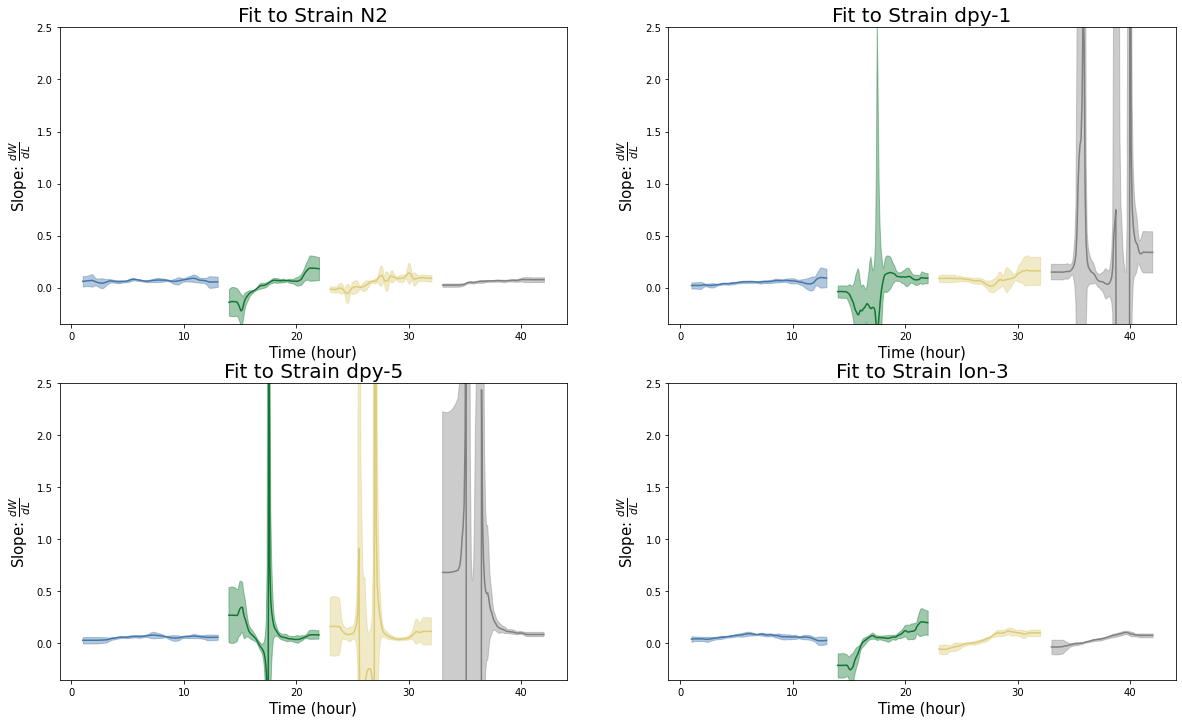

In [20]:
plt.rcParams["figure.figsize"] = (20,12)

c_cycle = ['#4477AA', '#117733', '#DDCC77', 'gray']

for r in range(4):
    Rep = r+1
    plt.subplot(2,2,Rep)
    for s in range(4):
        plt.plot(regtime_s[r,s],
                 np.divide(mean_dw[r,s],mean_dl[r,s]),
                 color = c_cycle[s])
        plt.fill_between(regtime_s[r,s],np.divide(mean_dw[r,s],mean_dl[r,s])-error[r,s],
                         np.divide(mean_dw[r,s],mean_dl[r,s])+error[r,s], color = c_cycle[s],alpha = 0.4)

    plt.xlabel('Time (hour)', fontsize = 15)
    plt.ylabel('Slope: $\\frac{dW}{dL}$', fontsize = 15)
    #plt.title('Slopes for all Replicates', fontsize = 20)
    plt.title('Fit to Strain ' + strain_types[r], fontsize = 20)
    plt.ylim([-0.35,2.5])
plt.show()

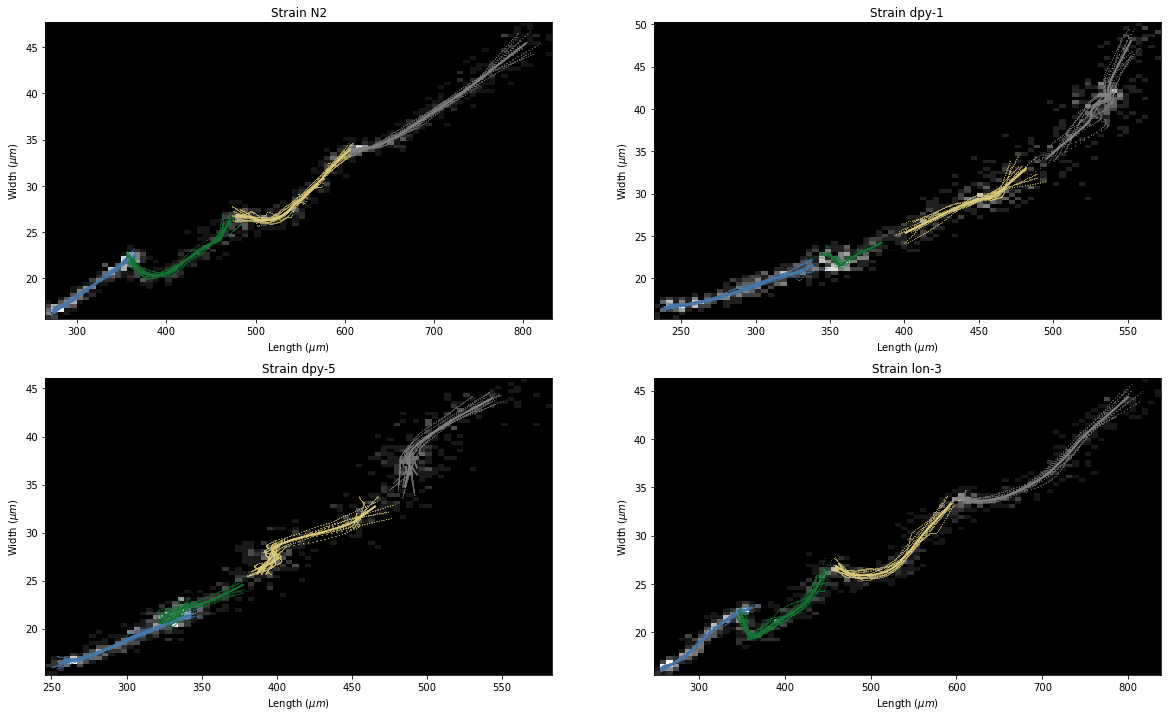

In [21]:
datalength = TOF_length(dataSS[:,1])
datawidth = nEXT_width(dataSS[:,2])
histogram = 'yes' #'no'

for r in range(4):
    gs = gridspec.GridSpec(2,2)
    plt.subplot(2,2,r+1)
    if histogram == 'yes':
        plt.hist2d(datalength[(strain_data == strain_types[r])],
                   datawidth[(strain_data == strain_types[r])],
                       bins = 80, cmap = 'gray', zorder = 0)
    else:
        plt.scatter(datalength[(strain_data == strain_types[r])],
                   datawidth[(strain_data == strain_types[r])],
                   color = 'black', alpha = 0.5, marker = '.', edgecolors='None')
        plt.ylim([230,700])
        plt.xlim([475,1200])
    plt.ylabel('Width ($\mu m$)')
    plt.xlabel('Length ($\mu m$)')

    for s in range(4):
        plt.plot(np.mean(lfit[r,s],axis = 0),
                 np.mean(wfit[r,s],axis = 0)
                 ,color = c_cycle[s],lw = 2, zorder = 5)
        counts,xbins,ybins = np.histogram2d((lfit[r,s]).flatten(),(wfit[r,s]).flatten(),
                                            bins=300,normed=True)
        plt.contourf(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     colors = c_cycle[s],
                     alpha = 0.4, levels = [0.1*np.max(counts),np.max(counts)], zorder = 5)
        plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
                     colors = c_cycle[s],
                     linewidths = 0.5, levels = [0.1*np.max(counts)], zorder = 5)
    plt.title('Strain '+strain_types[r])
plt.show()